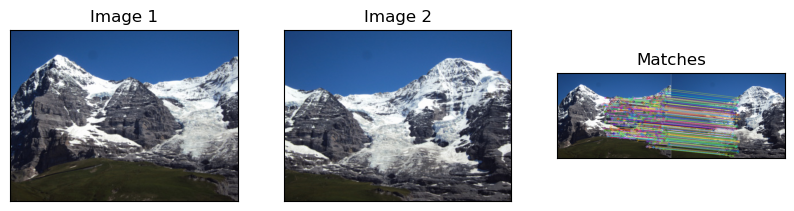

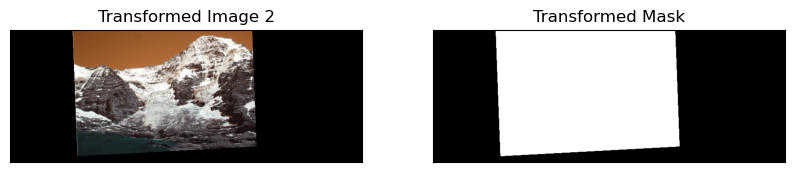

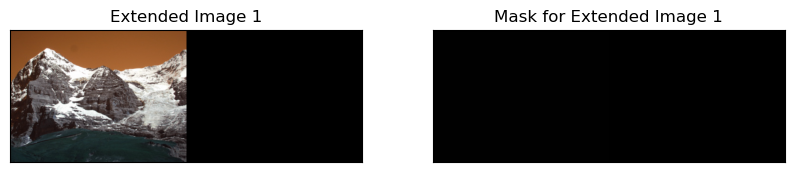

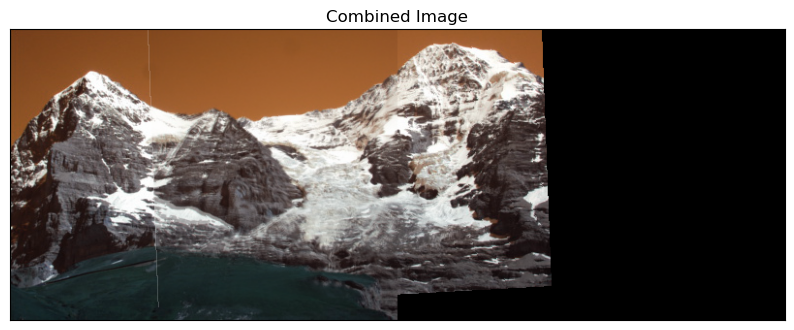

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load the images
image1 = cv2.imread('hill_left.jpg')
image2 = cv2.imread('hill_right.jpg')

# Convert images to grayscale
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Compute keypoints and descriptors
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

# Initialize BFMatcher
bf = cv2.BFMatcher()

# Perform KNN matching
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test
good = []
for m, n in matches:
    if m.distance < 0.5*n.distance:
        good.append([m])

# Draw good matches
img3 = cv2.drawMatchesKnn(image1, kp1, image2, kp2, good, None, flags=2)

# Convert images to RGB for plt.imshow() as OpenCV uses BGR
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

# Display the images
plt.figure(figsize=(10,10))

plt.subplot(131), plt.imshow(image1)
plt.title('Image 1'), plt.xticks([]), plt.yticks([])

plt.subplot(132), plt.imshow(image2)
plt.title('Image 2'), plt.xticks([]), plt.yticks([])

plt.subplot(133), plt.imshow(img3)
plt.title('Matches'), plt.xticks([]), plt.yticks([])

plt.show()

# Prepare lists of matched keypoints
src_pts = np.float32([ kp1[m[0].queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m[0].trainIdx].pt for m in good ]).reshape(-1,1,2)

# Estimate the affine transformation
M, _ = cv2.estimateAffine2D(src_pts, dst_pts)

# Transform the second image using the estimated transformation matrix
dst_size = (image1.shape[1] + image2.shape[1], max(image1.shape[0], image2.shape[0]))
transformed_image2 = cv2.warpAffine(image2, M, dst_size, flags=cv2.WARP_INVERSE_MAP)

# Create a mask of the second image
mask = np.ones_like(image2, dtype=np.uint8) * 255

# Apply the transformation to the mask
transformed_mask = cv2.warpAffine(mask, M, dst_size, flags=cv2.WARP_INVERSE_MAP)

# Convert the transformed images to RGB for display
transformed_image2_rgb = cv2.cvtColor(transformed_image2, cv2.COLOR_BGR2RGB)
transformed_mask_rgb = cv2.cvtColor(transformed_mask, cv2.COLOR_BGR2RGB)

# Display the transformed images and mask
plt.figure(figsize=(10,10))

plt.subplot(121), plt.imshow(transformed_image2_rgb)
plt.title('Transformed Image 2'), plt.xticks([]), plt.yticks([])

plt.subplot(122), plt.imshow(transformed_mask_rgb)
plt.title('Transformed Mask'), plt.xticks([]), plt.yticks([])

plt.show()

# Create a zero matrix with the shape of the transformed second image
extended_image1 = np.zeros_like(transformed_image2)

# Copy the original first image into the extended matrix
extended_image1[:image1.shape[0], :image1.shape[1]] = image1

# Create a zero mask with the shape of the transformed second image
mask1 = np.zeros((transformed_image2.shape[0], transformed_image2.shape[1]), dtype=np.uint8)

# Set the mask to 1 where the extended first image has content
mask1[:image1.shape[0], :image1.shape[1]] = 1

# Convert the extended image and mask to RGB for display
extended_image1_rgb = cv2.cvtColor(extended_image1, cv2.COLOR_BGR2RGB)
mask1_rgb = np.stack([mask1]*3, axis=-1)  # Replicate the mask to all color channels

# Display the extended image and mask
plt.figure(figsize=(10,10))

plt.subplot(121), plt.imshow(extended_image1_rgb)
plt.title('Extended Image 1'), plt.xticks([]), plt.yticks([])

plt.subplot(122), plt.imshow(mask1_rgb)
plt.title('Mask for Extended Image 1'), plt.xticks([]), plt.yticks([])

plt.show()

# Convert the masks to boolean for easier processing
mask1_bool = mask1.astype(bool)
transformed_mask_bool = transformed_mask[:,:,0].astype(bool)

# Create a zero matrix with the shape of the extended images
combined_image = np.zeros_like(extended_image1)

# Copy the content of the extended first image and transformed second image to the combined image
combined_image[mask1_bool] = extended_image1[mask1_bool]
combined_image[transformed_mask_bool] = transformed_image2[transformed_mask_bool]

# Identify the overlapping areas
overlap = mask1_bool & transformed_mask_bool

# Average the pixel values in the overlapping areas
combined_image[overlap] = (extended_image1[overlap].astype(np.int16) + transformed_image2[overlap].astype(np.int16)) // 2

# Convert the combined image to RGB for display
combined_image_rgb = cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB)

# Display the combined image
plt.figure(figsize=(10,10))
plt.imshow(combined_image_rgb)
plt.title('Combined Image'), plt.xticks([]), plt.yticks([])
plt.show()

